In [16]:
# Implemented by Hu Junfeng
# Time: 28/02/2022

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from flows import PlanarFlow
from torch.distributions import MultivariateNormal
from tqdm import tqdm
from visualization import plot_function, plot_model_hist

### Define energy functions in the paper

In [2]:
w1 = lambda x: torch.sin(2 * np.pi * x[:, 0] / 4)
w2 = lambda x: 3 * torch.exp(-0.5 * ((x[:, 0] - 1) / 0.6) ** 2)
w3 = lambda x: 3 * torch.sigmoid((x[:, 0] - 1) / 0.3)

def u1(z):
    """
    :param z: The first dimension means batch
    :return: value of the function
    """
    return 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2 \
           - torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
                      + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))

def u2(z):
    return 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2

def u3(z):
    return -torch.log(torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) +
                      torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2))

def u4(z):
    return -torch.log(torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2) +
                      torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2))

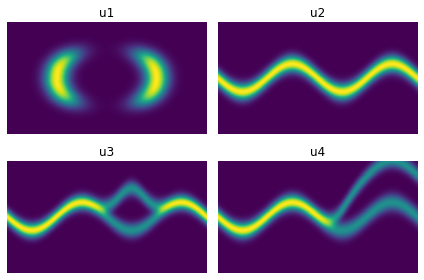

In [4]:
fig, axes = plt.subplots(2, 2)
for U, ax in zip([u1, u2, u3, u4], axes.flatten()):
    plot_function(U, ax)
    ax.set_title(U.__name__)
    ax.axis('off')

fig.tight_layout()
plt.show()

In [8]:
num_flow = 32
z_dim = 2
iteration = 5000
batch_size = 512
show_iter = 2000

def train(U):
    model = nn.ModuleList([PlanarFlow(z_dim) for i in range(num_flow)])
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    t = tqdm(range(iteration))
    for it in t:
        optimizer.zero_grad()

        # prior
        prior = MultivariateNormal(torch.zeros(z_dim), torch.eye(z_dim))
        z = prior.rsample([batch_size])
        logq = prior.log_prob(z)

        for flow in model:
            z, logq = flow(z, logq)

        U_z = U(z)
        loss = torch.mean(U_z + logq)
        loss.backward()
        t.set_description("Loss %f" % loss)

        optimizer.step()
    return model

### Train the model

In [9]:
model_list = []
for U in [u1, u2, u3, u4]:
    model_list.append(train(U))

Loss -2.847144: 100%|██████████| 5000/5000 [01:15<00:00, 66.64it/s]


Sampling..........Sampling..........Sampling..........Sampling..........

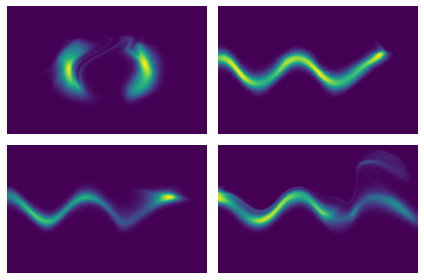

In [17]:
fig, axes = plt.subplots(2, 2)
for model, ax in zip(model_list, axes.flatten()):
    plot_model_hist(model, ax)
    ax.axis('off')

fig.tight_layout()
plt.show()